### Import Packges

In [1]:
import PyPDF2 as pdf
import warnings
import logging
import slate3k as slate # Reading PDF files orderly
from nltk.tokenize import word_tokenize
from nltk.text import Text
import nltk
import numpy as np

import re
import os
from tqdm import tqdm # Progress meter
from langdetect import detect # For language detection
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # For sentiment analysis
import spacy
from gensim import models, corpora
import textract
from wordcloud import WordCloud

import pdfquery
import pandas as pd
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
# Disable logging for PDFMiner
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

In [2]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [3]:
pdf_list = []
path_src = './updated_sources/'
path_dst = './pdf_text/'
nlp = spacy.load('en_core_web_sm') # Load english model from spacy

#Get list of pdf's to be read
for f in os.listdir(path_src):
    if f.endswith('.pdf') or f.endswith('.PDF'):
        pdf_list.append(f[0:len(f)-4])
        
#trouble        
for i in range(len(pdf_list)):
    print(pdf_list[i])

Boeing_2017
cardinal_health_inc_2018
citigroup_2018
costco_wholesale_2017
FedEx_2018
Ford_motor_company_2018
Home_Depot_inc_2018
The_Kroger_2017
Wells_Fargo


# Extracting with Textract

###### Function that removes some regular expressions

In [4]:
def remove_regexs(text):
    
    #replace python notation string representing apostrophes
    patterns = [r"\\xe2\\x80\\x99", r"\\xe2\\x80\\x98"]
    for pattern in patterns:
        text = re.sub(pattern, "'", text)

    #replace python notation string representing hyphen    
    patterns = [r"\\xe2\\x80\\x93", r"\\xe2\\x80\\x94",r"\\xad",r"\\x96"] 
    for pattern in patterns:
        text = re.sub(pattern, '-', text)
        
    #replace python notation string representing whitespaces and special charachters
    patterns = [r"\\x0c", r"\\x0b", r"\\xe2\\x80\\xa2", # '\xe2\x80\xa2' = bullet point
               r"\\xe2\\x80\\xa0", r"\\t"]                      # '\xe2\x80\xa0' = dagger
    for pattern in patterns:                            
        text = re.sub(pattern, '', text)
    
    #replace python notation string representing double quote
    patterns = [r"\\xe2\\x80\\x9c", r"\\xe2\\x80\\x9d"]
    for pattern in patterns:
        text = re.sub(pattern, '"', text)
    
    #replace accented 'a' characters with a
    patterns = [r"\\xc3\\xa0", r"\\xc3\\xa1", r"\\xc3\\xa2", 
                r"\\xc3\\xa3", r"\\xc3\\xa4", r"\\xc3\\xa5"]
    for pattern in patterns:
        text = re.sub(pattern, 'a', text)
    
    #replace accented 'e' characters with e
    patterns = [r"\\xc3\\xa9", r"\\xc3\\xa8", r"\\xc3\\xaa", 
                r"\\xc3\\xab"]
    for pattern in patterns:
        text = re.sub(pattern, 'e', text)
        
    # Euro sign
    patterns = [r"\\xa3"]
    for pattern in patterns:
        text = re.sub(pattern,'£',text)
    
    # Yen sign
    patterns = [r"\\xa5"]
    for pattern in patterns:
        text = re.sub(pattern, '¥', text)
        
    #replace accented 'u' characters with u
    patterns = [r"\\xc3\\x9c", r"\\xc3\\xbc"]
    for pattern in patterns:
        text = re.sub(pattern, 'u', text)
    
    #replace euro symbol for ''
    patterns = [r"\\xe2\\x82\\xac", r'\\u', r'\\U', r"\\2"]
    for pattern in patterns:
        text = re.sub(pattern, '', text)
        
    # replace other special characters like DIAERESIS, REGISTERED SIGN, etc with ''
    patterns = [r"\\x0c", r"\\xc2", r"\\xc3", r"\\xb7",r"\\xa7",r"\\xae",
                r"\\xa8",r"\\x89",r"\\xbe","\\xa9", r"\\r",r'\\\'',r"b'"]
    for pattern in patterns:
        text = re.sub(pattern,'', text)
    
        
    return text

In [5]:
text_data = {} # Dictionary to carry documents
documents = []
for fl in tqdm(pdf_list):
    file = open(path_dst + fl +'-cleaned' + '.txt' , 'w+', encoding='utf-8')
    path = 'updated_sources/' + fl + '.pdf'
    text = textract.process(path)
    
    output = str(text).replace('\\n', '\r')
    output = remove_regexs(output)
    
    text_data[fl] = output # Add document to dictionary
    documents.append(output) # Add documents to List
    
    file.write(output)
    file.close()

100%|██████████| 9/9 [00:01<00:00,  5.63it/s]


In [37]:
# documents[1]

## Preprocessing with NLTK

In [6]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = stopwords.words('english')
new_stopwords = ['company','2018','2017','2016', 'boeing','kroger','krogers','citi','737','777x','costco','us','1','fedex','ford']
stop.extend(new_stopwords)
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

In [7]:
# List of Documents
documents

['TO THE SHAREHOLDERS AND EMPLOYEES OF THE BOEING COMPANY\rDennis A. Muilenburg Chairman, President and Chief Executive Officer 2\r\rIn the first full year of our second century, we worked together with accelerated pace and purpose to be the best in aerospace and an enduring global industrial champion. For a company that dreams big and delivers on those dreams, a bold, bright future is ours to seize-- and we will do so, together.\r\r2017 in Review\rIn 2017, more than 140,000 dedicated Boeing employees around the world delivered record company financial and operational performance, strengthened our businesses for profitable, long-term growth, and drove additional productivity and quality gains across the enterprise. Our strong performance trend--underpinned by our sizeable backlog, a large and growing aerospace and defense market, and our positive future outlook--helped make Boeing the Dows top-performing company in 2017, as measured by stock price and total shareholder returns.\rCompan

In [8]:
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free  if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
#     print(documents)
    return normalized

doc_clean = [clean(doc).split() for doc in documents] # Clean and then tokenize corpus for use in Gensim LDA
doc_clean_sk = [clean(doc) for doc in documents] # Clean but do not tokenize corpus for use in Scikit-Learn LDA

In [9]:
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free  if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized


### Visualization CloudWord
with sizes proportional to their frequency in the text.

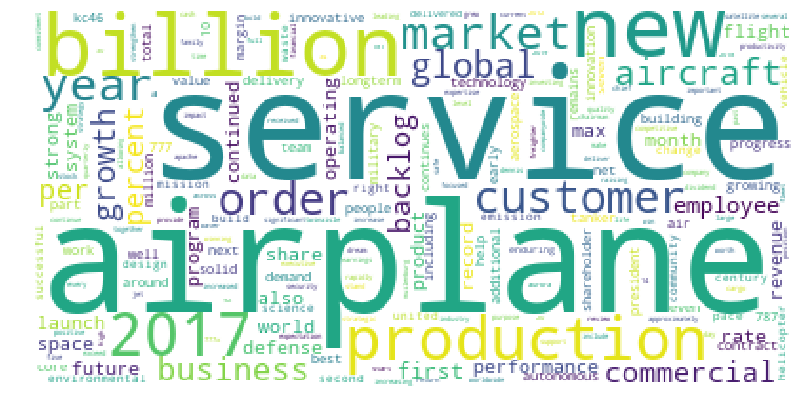

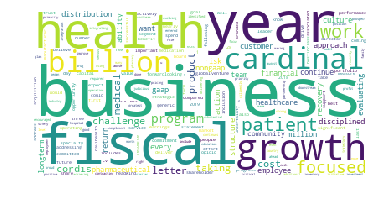

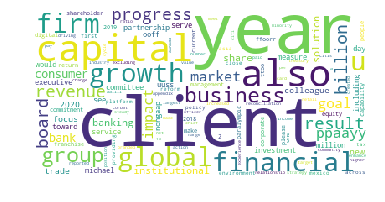

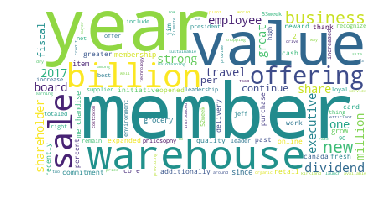

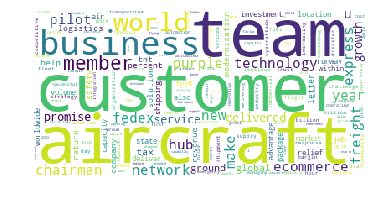

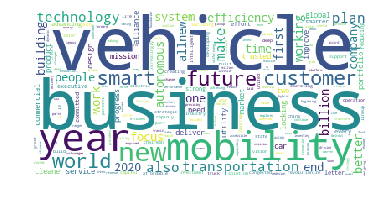

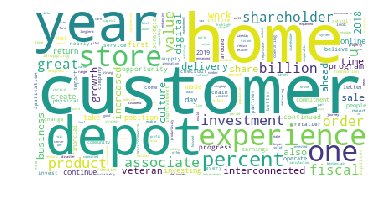

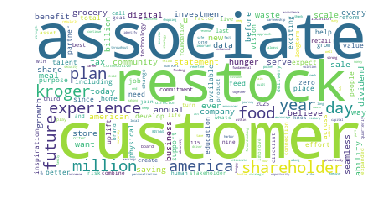

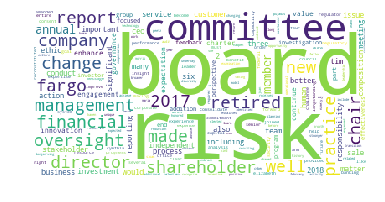

In [10]:
# frequency_dist = nltk.FreqDist(doc_clean[4])
fig, ax = plt.subplots(1,1,figsize = (20,7))

for f in range(len(doc_clean)):
    frequency_dist = nltk.FreqDist(doc_clean[f])
    wordcloud = WordCloud(background_color="white", repeat=True).generate_from_frequencies(frequency_dist)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

### Gensim Bigrams/Trigrams

In [11]:
import gensim
bigram = gensim.models.Phrases(doc_clean, min_count = 5, threshold=100 )
trigram = gensim.models.Phrases(bigram[doc_clean], threshold = 100)

In [12]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [13]:
print(bigram_mod[doc_clean[1]])

['dear', 'fellow', 'shareholder', 'investor', 'cardinal_health', 'put', 'trust', 'responsible', 'steward', 'capital', 'want', 'begin', 'first', 'letter', 'chief_executive', 'officer', 'sharing', 'going', 'past', 'several', 'year', 'set', 'achieved', 'number', 'important', 'strategic', 'goal', 'three', 'significant', 'were', 'grew', 'specialty', 'business', '1', 'billion', 'mostly', 'blood', 'product', 'business', '15', 'billion', 'business', 'offering', 'diversified', 'service', 'manufacturer', 'provider', 'partnered', 'cv', 'health', 'build', 'bestinclass', 'largescale', 'generic', 'program', 'successful', '5050', 'joint', 'venture', 'significantly', 'expanded', 'medical', 'product', 'portfolio', 'organic', 'expansion', 'acquisition', 'cordis', 'patient', 'recovery', 'business', 'complement', 'medical', 'distribution', 'capability', 'encouraged', 'strategic', 'progress', 'weve', 'made', 'committed', 'making', 'stride', 'coming', 'year', 'moving', 'aggressively', 'address', 'challenge'

In [14]:
type(doc_clean)

list

In [15]:
from nltk.util import ngrams

# Takes in a list of document(s) tokens
def generate_ngrams(documents, n):
    
    output = []
    
    for doc in documents:
        grams = list(ngrams(doc, n))
        output.append(grams) # Add generated ngrams to list
    
    return output

In [16]:
grams = generate_ngrams(doc_clean, 4)
grams

[[('shareholder', 'employee', 'dennis', 'a'),
  ('employee', 'dennis', 'a', 'muilenburg'),
  ('dennis', 'a', 'muilenburg', 'chairman'),
  ('a', 'muilenburg', 'chairman', 'president'),
  ('muilenburg', 'chairman', 'president', 'chief'),
  ('chairman', 'president', 'chief', 'executive'),
  ('president', 'chief', 'executive', 'officer'),
  ('chief', 'executive', 'officer', '2'),
  ('executive', 'officer', '2', 'first'),
  ('officer', '2', 'first', 'full'),
  ('2', 'first', 'full', 'year'),
  ('first', 'full', 'year', 'second'),
  ('full', 'year', 'second', 'century'),
  ('year', 'second', 'century', 'worked'),
  ('second', 'century', 'worked', 'together'),
  ('century', 'worked', 'together', 'accelerated'),
  ('worked', 'together', 'accelerated', 'pace'),
  ('together', 'accelerated', 'pace', 'purpose'),
  ('accelerated', 'pace', 'purpose', 'best'),
  ('pace', 'purpose', 'best', 'aerospace'),
  ('purpose', 'best', 'aerospace', 'enduring'),
  ('best', 'aerospace', 'enduring', 'global'),
  

### Create a vocabulary for the LDA Model and convert our corpus into document-term matrix

In [17]:
dictionary = None
for i in range(len(grams)):
    dictionary = corpora.Dictionary(grams[i])
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean] # Create a Bag-of-Words

### Define Multi-Core LDA
LDA Model is trained on all documents in new_sources directory.

In [18]:
num_topic = 5
Lda = models.LdaMulticore
lda= Lda(doc_term_matrix, num_topics=num_topic, id2word = dictionary,
         passes=50,chunksize=2000,random_state=3)

### Print topics found

In [19]:
for i, topic in lda.show_topics(formatted=True, num_topics=num_topic, num_words=10, log=False):
    print(str(i)+":  "+ topic)
    print()
    print()

0:  0.002*"year" + 0.002*"board" + 0.002*"business" + 0.002*"customer" + 0.002*"risk" + 0.002*"capital" + 0.002*"billion" + 0.002*"annual" + 0.002*"practice" + 0.002*"growth"


1:  0.054*"customer" + 0.038*"experience" + 0.020*"shareholder" + 0.019*"investment" + 0.018*"year" + 0.016*"future" + 0.014*"community" + 0.014*"plan" + 0.014*"sale" + 0.014*"u"


2:  0.040*"board" + 0.025*"risk" + 0.021*"committee" + 0.019*"management" + 0.018*"oversight" + 0.016*"director" + 0.014*"company" + 0.013*"fargo" + 0.012*"change" + 0.011*"well"


3:  0.023*"year" + 0.019*"growth" + 0.019*"capital" + 0.017*"also" + 0.016*"business" + 0.016*"financial" + 0.014*"u" + 0.013*"goal" + 0.012*"board" + 0.012*"billion"


4:  0.032*"business" + 0.029*"year" + 0.021*"customer" + 0.020*"new" + 0.019*"billion" + 0.018*"service" + 0.013*"growth" + 0.013*"member" + 0.013*"percent" + 0.013*"value"




### Exploration
This visualization allows us to compare topics on two reduced dimensions and observe the distribution of words in each topic.

In [20]:
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda, corpus=doc_term_matrix, dictionary=dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [52]:
analyzer = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(text_data):
    score = analyzer.polarity_scores(text_data)
    print("{:-<40} \n\n\nSentiment: {} ".format(text_data, str(score)))

### Topic extraction on unseen data

In [24]:
### Load documents from "sources" directory
test_pdf_list = []
test_path_src = './updated_test_sources/'
test_path_dst = './pdf_text/'

#Get list of pdf's to be read
for f in os.listdir(test_path_src):
    if f.endswith('.pdf') or f.endswith('.PDF'):
        test_pdf_list.append(f[0:len(f)-4])
        
#trouble        
for i in range(len(test_pdf_list)):
    print(test_pdf_list[i])

amazon_2017
berkshire_hathaway_2017
mckesson_2017
pepsi_co_2017
walmart_2017


In [40]:
txt = "Empowering Small Business - Millions of small and medium-sized businesses worldwide now sell their products through Amazon to reach new customers around the globe. SMBs selling on Amazon come from every state in the U.S., and from more than 130 different countries around the world. More than 140,000 SMBs surpassed $100,000 in sales on Amazon in 2017, and over a thousand independent authors surpassed $100,000 in royalties in 2017 through Kindle Direct Publishing.  Investment & Job Creation - Since 2011, we have invested over $150 billion worldwide in our fulfillment networks, transportation capabilities, and technology infrastructure, including AWS data centers. Amazon has created over 1.7 million direct and indirect jobs around the world. In 2017 alone, we directly created more than 130,000 new Amazon jobs, not including acquisitions, bringing our global employee base to over 560,000. Our new jobs cover a wide range of professions, from artificial intelligence scientists to packaging specialists to fulfillment center associates. In addition to these direct hires, we estimate that Amazon Marketplace has created 900,000 more jobs worldwide, and that Amazons investments have created an additional 260,000 jobs in areas like construction, logistics, and other professional services.  Career Choice - One employee program were particularly proud of is Amazon Career Choice. For hourly associates with more than one year of tenure, we pre-pay 95% of tuition, fees, and textbooks (up to $12,000) for certificates and associate degrees in high-demand occupations such as aircraft mechanics, computer-aided design, machine tool technologies, medical lab technologies, and nursing. We fund education in areas that are in high demand and do so regardless of whether those skills are relevant to a career at Amazon. Globally more than 16,000 associates (including more than 12,000 in the U.S.) have joined Career Choice since the program launched in 2012. Career Choice is live in ten countries and expanding to South Africa, Costa Rica, and Slovakia later this year. Commercial truck driving, healthcare, and information technology are the programs most popular fields of study."

In [53]:
sentiment_analyzer_scores(txt)

Empowering Small Business - Millions of small and medium-sized businesses worldwide now sell their products through Amazon to reach new customers around the globe. SMBs selling on Amazon come from every state in the U.S., and from more than 130 different countries around the world. More than 140,000 SMBs surpassed $100,000 in sales on Amazon in 2017, and over a thousand independent authors surpassed $100,000 in royalties in 2017 through Kindle Direct Publishing.  Investment & Job Creation - Since 2011, we have invested over $150 billion worldwide in our fulfillment networks, transportation capabilities, and technology infrastructure, including AWS data centers. Amazon has created over 1.7 million direct and indirect jobs around the world. In 2017 alone, we directly created more than 130,000 new Amazon jobs, not including acquisitions, bringing our global employee base to over 560,000. Our new jobs cover a wide range of professions, from artificial intelligence scientists to packaging s

###### Extract Text

In [25]:
test_text_data = {} # Dictionary to carry documents
test_documents = []
for fl in tqdm(test_pdf_list):
    file = open(test_path_dst + fl +'-cleaned' + '.txt' , 'w+', encoding='utf-8')
    path = 'updated_test_sources/' + fl + '.pdf'
    text = textract.process(path)
    
    output = str(text).replace('\\n', '\r')
    output = remove_regexs(output)
    
    test_text_data[fl] = output # Add document to dictionary
    test_documents.append(output) # Add documents to List
    
    file.write(output)
    file.close()

100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


#### 1. Topic extraction on particular section of text

In [26]:
substring = test_documents[0] # [11431:14127]
print(substring)
tokens = word_tokenize(substring)
topics = lda.show_topics(formatted = True, num_topics = 5)
pd.DataFrame([(el[0], round(el[1],2), topics[el[0]][1]) for el in lda[dictionary.doc2bow(tokens)]], columns=['topic #', 'weight', 'words in topic'])

'

,topic #,weight,words in topic
0,1,0.23,"0.054*""customer"" + 0.038*""experience"" + 0.020*..."
1,2,0.10,"0.040*""board"" + 0.025*""risk"" + 0.021*""committe..."
2,3,0.08,"0.023*""year"" + 0.019*""growth"" + 0.019*""capital..."
3,4,0.59,"0.032*""business"" + 0.029*""year"" + 0.021*""custo..."


#### 2. Topic  extraction on entire document

In [27]:
tokens = word_tokenize(test_documents[1])
topics = lda.show_topics(formatted = True, num_topics = 5)
pd.DataFrame([(el[0], round(el[1],2), topics[el[0]][1]) for el in lda[dictionary.doc2bow(tokens)]], columns=['topic #', 'weight', 'words in topic'])

,topic #,weight,words in topic
0,1,0.16,"0.054*""customer"" + 0.038*""experience"" + 0.020*..."
1,2,0.19,"0.040*""board"" + 0.025*""risk"" + 0.021*""committe..."
2,3,0.21,"0.023*""year"" + 0.019*""growth"" + 0.019*""capital..."
3,4,0.44,"0.032*""business"" + 0.029*""year"" + 0.021*""custo..."


## LDA and Grid Search With Scikit-Learn


In [28]:
from sklearn.decomposition import NMF, LatentDirichletAllocation as LDA
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

no_features = 1000
no_topics = 5

custom_stop_words = text.ENGLISH_STOP_WORDS.union(new_stopwords) # Add Custom stopwords to CountVectorizer's stopword list
vectorizer = CountVectorizer(stop_words=custom_stop_words, ngram_range=(2,3)) 

# count_vectorizer
data_vectorized = vectorizer.fit_transform(doc_clean_sk)

In [29]:
vectorizer.fit(doc_clean_sk).vocabulary_

{'shareholder employee': 16353,
 'employee dennis': 6470,
 'dennis muilenburg': 5574,
 'muilenburg chairman': 12060,
 'chairman president': 3537,
 'president chief': 13865,
 'chief executive': 3687,
 'executive officer': 7005,
 'officer year': 12568,
 'year second': 19506,
 'second century': 15943,
 'century worked': 3456,
 'worked accelerated': 19190,
 'accelerated pace': 927,
 'pace purpose': 13004,
 'purpose best': 14402,
 'best aerospace': 2395,
 'aerospace enduring': 1298,
 'enduring global': 6573,
 'global industrial': 8370,
 'industrial champion': 9753,
 'champion dream': 3582,
 'dream big': 6018,
 'big delivers': 2491,
 'delivers dream': 5497,
 'dream bold': 6020,
 'bold bright': 2745,
 'bright future': 2796,
 'future seize': 8197,
 'seize review': 16011,
 'review 140000': 15475,
 '140000 dedicated': 153,
 'dedicated employee': 5341,
 'employee world': 6497,
 'world delivered': 19246,
 'delivered record': 5470,
 'record financial': 14687,
 'financial operational': 7560,
 'opera

In [30]:
# docs = np.array(documents)
lda = LDA(n_components = no_topics, n_jobs = 1)
lda.fit(data_vectorized)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [31]:
print_topics(lda, vectorizer, 10)


Topic #0:
home depot cardinal health financial measure forwardlooking statement patient recovery recovery business patient recovery business fiscal year longterm growth cost structure

Topic #1:
product service new order autonomous vehicle united state defense space global service airplane month commercial airplane net new order service market

Topic #2:
team member purple promise letter chairman purple runway ecommerce growth aircraft fleet north america commercial pilot delta state aircraft fleet modernization

Topic #3:
board director risk management risk committee annual report customer experience sale practice team member financial performance value member digital experience

Topic #4:
nongaap financial measure nongaap financial financial measure institutional client institutional client group client group global consumer tax reform measure reconciliation financial measure reconciliation


In [32]:
data_dense = data_vectorized.todense()
print("Sparsicity: ", ((data_dense > 0).sum() / data_dense.size) * 100, "%")

Sparsicity:  11.336965157189876 %


### Diagnose model performance with perplexity and log-likelihood
A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.

In [33]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(data_vectorized))

# See model parameters
print(lda.get_params())

Log Likelihood:  -213198.97301163306
Perplexity:  27152.161712677746
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 5, 'n_jobs': 1, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


### GridSearch to find the best LDA model

In [34]:
# Define Search Param
# n_components = number of Topics
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LDA()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

### Best topic Model and its parameters

In [35]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -98426.4302606259
Model Perplexity:  34687.20304635899


In [36]:
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6      32.420952   8.115230       1        1  32.365565
8       0.648955  71.707100       2        1  24.684674
4      71.019684   9.971006       3        1  16.084374
2       3.785981  33.185135       4        1  11.180865
0     -42.666500  -9.222070       5        1   9.045157
1      -3.621689 -43.526516       6        1   6.622134
9      -3.632402  -4.171708       7        1   0.004308
7     -36.584400  35.804413       8        1   0.004308
5      44.391380  50.615383       9        1   0.004308
3      40.235809 -31.591665      10        1   0.004308, topic_info=      Category       Freq                  Term      Total  loglift  logprob
17657  Default  12.000000           team member  12.000000  30.0000  30.0000
9114   Default  11.000000            home depot  11.000000  29.0000  29.0000
3289   Default   6.000000       cardinal health   6.000000  28.0000  28.0000
15546  Default   5.000000        risk committee   5.000000  27.0000  27.0000
14390  Default   5.000000        purple promise   5.000000  26.0000  26.0000
...        ...        ...                   ...        ...      ...      ...
1966   Topic10   0.000046  associate experience   1.858024  -0.5551  -9.8823
3316   Topic10   0.000046         career growth   1.858024  -0.5551  -9.8823
6728   Topic10   0.000046  environmental social   1.858024  -0.5551  -9.8823
16540  Topic10   0.000046          simple truth   1.858024  -0.5551  -9.8823
10650  Topic10   0.000046       leadership team   1.987756  -0.6226  -9.8823

[588 rows x 6 columns], token_table=       Topic      Freq                 Term
term                                       
48         4  0.691568         10k attached
49         4  0.691568  10k attached letter
73         5  0.746141             115 year
88         3  0.616646          12 airplane
89         3  0.616646    12 airplane month
...      ...       ...                  ...
19464      4  0.460702         year nongaap
19484      3  0.616646      year production
19493      1  0.417211          year record
19493      3  0.417211          year record
19531      6  0.843132         year totaled

[437 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 5, 3, 1, 2, 10, 8, 6, 4])